### 1. Import necessary libraries

In [1]:
import os
import time
import math
import warnings
import random
from collections import OrderedDict
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score
import pickle
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F
import torch.optim as optim
import torchmetrics
import torchvision.datasets as dset
import torchvision.transforms as T
from torchvision import models
from torch.utils.data import DataLoader, sampler, random_split, TensorDataset
import timm

# turn off warnings
warnings.filterwarnings("ignore")
# set environment to solve the conflict between pytorch and matplotlib
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

### 2. Configure PyTorch environment

In [2]:
# define the configuration of pytorch
gpu_index = torch.randint(0, torch.cuda.device_count(), (1,)).item()
dtype = torch.float
device = torch.device('cuda:{}'.format(gpu_index))
print("PyTorch is using GPU {}!".format(device))

PyTorch is using GPU cuda:0!


In [3]:
# define a function that returns a consistent, predetermined random number
def fix_random_seed(seed=0):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if using multi-GPU
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

### 3. Bin price target into 8 categories for classification task

In [4]:
# read the guitar info
df = pd.read_csv("guitar_info.csv")

# load the valid guitar image indice
train_data_id = []
file_path = "guitar_resized_images"

# walk through all resized guitar images
for root, dirs, files in os.walk(file_path):
    for file in files:
        train_data_id.append(int(file.replace(".png","")))
        
# select the guitar info of resized images
df = df[df['index'].isin(train_data_id)]
df['price'] = df['price'].apply(lambda x:math.ceil(float(x.replace("$","").replace(",",""))))

# remove 36 outliers that have exorbitant price 
df = df[df['price']<5000]

# split the price into 8 different ranges
num_bins = 8
bins = [0, 200, 400, 600, 800, 1100, 1500, 2200, 5000]
labels = [f'Price_Bin_{i+1}' for i in range(num_bins)]

# perform the quantile binning
df['price_bin'] = pd.cut(df['price'], bins = bins, labels=labels, right=True, include_lowest=True)

# concatenate the price bins
df = pd.concat([df,pd.get_dummies(df['price_bin'])],axis=1)

# display the price interval
for label, lower_bound, upper_bound in zip(labels, bins[:-1], bins[1:]):
    print(f"{label}: ({lower_bound:.0f}, {upper_bound:.0f}]")
    
# add the path of images to dataframe
df['path'] = df['index'].apply(lambda x:'guitar_resized_images/000000'+ str(x) + '.png')

Price_Bin_1: (0, 200]
Price_Bin_2: (200, 400]
Price_Bin_3: (400, 600]
Price_Bin_4: (600, 800]
Price_Bin_5: (800, 1100]
Price_Bin_6: (1100, 1500]
Price_Bin_7: (1500, 2200]
Price_Bin_8: (2200, 5000]


### 4. Augment images and prepare datasets

In [5]:
# define a class to generate training, validation, and testing set
class Guitar_Image_Data_Set:
    """ this class is designed to generate training, validation, and testing set from guitar images"""
    def __init__(self, dataframe, transform):
        self.df = dataframe
        self.tf = transform
        
    def __len__(self):
        return self.df.shape[0]
    
    def __getitem__(self, idx):
        # retrieve the image based on the file path
        path_idx = self.df['path'].iloc[idx]

        # apply the transformation to images
        image = Image.open(path_idx)
        transform = self.tf
        image = transform(image)
        image = image.to(device=device, dtype=dtype)

        # convert price from dataframe to torch.tensor
        price = torch.tensor(self.df[labels].iloc[idx], device=device, dtype=dtype)
        price = price.to(device=device, dtype=dtype)
        
        return image, price
    
    
# define a function to calculate the mean and std of RGB channels for groups of images
def normal_para(df, transformer):
    tensors = []
    # walk through all images and convert them to tensors
    for path in df['path'].values:
        image = Image.open(path)
        tensor = transformer(image)
        tensors.append(tensor)

    # stack all tensors into a single tensor
    tensor_stack = torch.stack(tensors, dim=0)

    # calculate the mean and std
    mean = torch.mean(tensor_stack, dim=[0, 2, 3])
    std = torch.std(tensor_stack, dim=[0, 2, 3])
    
    return mean,std

# define a function to extract small number of batches.
def subset_of_dataloader(dataloader, num_batches):
    subset_data = []
    for i, data in enumerate(dataloader):
        subset_data.append(data)
        if i + 1 == num_batches:
            break
    return subset_data

In [6]:
# define a tensor transformer
image_transformer = T.ToTensor()

# calculate the mean and std of RGB channels for different types of images
mean, std = normal_para(df, image_transformer)

In [7]:
# create transformors to normalize images
fix_random_seed()
transform = T.Compose([T.RandomRotation(degrees=(-15, 15)), # randomly rotate images to increase data diversity
                       T.RandomHorizontalFlip(),  # randomly flip images to further increase data diversity
                       T.RandomApply([T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2)], p=0.3), # randomly color jitter images to increase data diversity
                       T.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.8, 1.2)),  # randomly affline images to increase data diversity
                       T.RandomPerspective(distortion_scale=0.2, p=0.3),  # randomly change the perspective of images to increase data diversity
                       T.ToTensor(),
                       T.Normalize(mean, std) 
])

# create an instance of the Dataset
guitar_dataset = Guitar_Image_Data_Set(dataframe = df,transform = transform)

In [8]:
# create training, validation, and testing data set
fix_random_seed()

# define the ratio for training, validation, and testing set
total = len(guitar_dataset)
train = 0.7
validation = 0.15

# split the whole dataset into training, validation, and testing set
train_size = int(train * total)
validation_size = int(validation * total)
test_size = total - train_size - validation_size
train_dataset, validation_dataset, test_dataset = random_split(guitar_dataset, [train_size, validation_size, test_size])

loader_train = DataLoader(train_dataset, batch_size = 32,shuffle = True)
loader_val = DataLoader(validation_dataset, batch_size = 32,shuffle = True)
loader_test = DataLoader(test_dataset, batch_size = 32,shuffle = True)
# extract small number of batches from training set to determine the model architecture, learning rate, etc
loader_small = subset_of_dataloader(loader_train, 10)

### 5. Train models using different algorithms

In [9]:
# define a function for adjusting learning rate
def adjust_learning_rate(optimizer, lrd, epoch, schedule):
    """
    Multiply lrd to the learning rate if epoch is in schedule

    Inputs:
    - optimizer: An Optimizer object we will use to train the model
    - lrd: learning rate decay; a factor multiplied at scheduled epochs
    - epochs: the current epoch number
    - schedule: the list of epochs that requires learning rate update

    Returns: Nothing, but learning rate might be updated
    """
    if epoch in schedule:
        for param_group in optimizer.param_groups:
            print('lr decay from {} to {}'.format(param_group['lr'], param_group['lr'] * lrd))
            param_group['lr'] *= lrd


# define a function to initialize the weight
def initialize_weight(m, init_type):
    if isinstance(m, nn.Linear):
        if init_type == 'kaiming':
            init.kaiming_uniform_(m.weight, mode='fan_in', nonlinearity='relu')
        elif init_type == 'xavier':
            init.xavier_uniform_(m.weight)
        elif init_type == 'uniform':
            init.uniform_(m.weight, a=-0.1, b=0.1)
        if m.bias is not None:
            init.zeros_(m.bias)          
            

# define a function for training the model
def train_model(model, optimizer, dataset, epochs=1, learning_rate_decay=.1, schedule=[], criterion = nn.CrossEntropyLoss(), print_every = 100, validate = True):
    """
    Train a model on guitar image dataset using the PyTorch Module API.

    Inputs:
    - model: A PyTorch Module giving the model to train.
    - optimizer: An Optimizer object we will use to train the model
    - epochs: (Optional) A Python integer giving the number of epochs to train for

    Returns: Nothing, but prints model accuracies during training.
    """
     # define a list to record the model performance in each iteration
    train_acc = []
    val_acc = []
    result = []
    num_iters = epochs * len(dataset)
    num_prints = num_iters // print_every + 1

    for e in range(epochs):
        
        adjust_learning_rate(optimizer, learning_rate_decay, e, schedule)

        for t, (x, y) in enumerate(dataset):
            model.train()  # put the model to training mode
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=dtype)
            outputs = model(x)
            
            # calculatet the loss using assigned criterion 
            loss = criterion(outputs, y)
            
            # zero out all of the gradients for the variables which the optimizer will update.
            optimizer.zero_grad()

            # this is the backwards pass: compute the gradient of the loss with
            # respect to each  parameter of the model.
            loss.backward()

            # actually update the parameters of the model using the gradients
            # computed by the backwards pass.
            optimizer.step()
            
            result.append((e+1,t+1,loss.item()))
            
            if validate and t % print_every == 0:
                model.eval() # put the model to evaluation mode
                _, accuracy, _, _, _ = evaluate_model(model, dataset, 8)
                val_loss, val_accuracy, _, _, _ = evaluate_model(model, loader_val, 8)
                train_acc.append((e + 1, accuracy))
                val_acc.append((e + 1, val_accuracy))
                print('Epoch %d, Iteration %d, loss = %.4f, val_loss = %.4f, accuracy = %.4f, val_accuracy = %.4f' % (e, t, loss.item(), val_loss, accuracy, val_accuracy))
            elif not validate and t % print_every == 0:
                print('Epoch %d, Iteration %d, loss = %.4f' % (e, t, loss.item()))

    return train_acc, val_acc, result


# define a function to evaluate the model performance
def evaluate_model(model, dataset, num_classes):
    model.to(device).eval()  # Move model to device and set to evaluation mode
    criterion = torch.nn.CrossEntropyLoss()  # Assuming you're using CrossEntropyLoss

    accuracy = torchmetrics.Accuracy(average='weighted', num_classes=num_classes, task='multiclass').to(device)
    precision = torchmetrics.Precision(average='weighted', num_classes=num_classes, task='multiclass').to(device)
    recall = torchmetrics.Recall(average='weighted', num_classes=num_classes, task='multiclass').to(device)
    f1 = torchmetrics.F1Score(average='weighted', num_classes=num_classes, task='multiclass').to(device)

    total_loss = 0
    total_count = 0

    with torch.no_grad():
        for images, labels in dataset:
            labels = torch.argmax(labels, dim=1) 
            images, labels = images.to(device=device), labels.to(device=device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * labels.size(0)
            total_count += labels.size(0)

            _, predicted = torch.max(outputs, 1)
            accuracy.update(predicted, labels)
            precision.update(predicted, labels)
            recall.update(predicted, labels)
            f1.update(predicted, labels)

    # Compute final metrics
    final_loss = total_loss / total_count
    final_accuracy = accuracy.compute()
    final_precision = precision.compute()
    final_recall = recall.compute()
    final_f1 = f1.compute()
    
    return final_loss, final_accuracy.item(), final_precision.item(), final_recall.item(), final_f1.item()


# define a function to visualize the accuracy in the training process
def plot_accuracy(train,val):
    df_train = pd.DataFrame(train,columns = ['epoch','accuracy'])
    df_val = pd.DataFrame(val,columns = ['epoch','accuracy'])
    sns.lineplot(data = df_train, x = 'epoch', y = 'accuracy',c ='blue',linewidth = 4 ,label = 'train')
    sns.lineplot(data = df_val, x = 'epoch', y = 'accuracy',c ='red',linewidth = 4 ,label = 'validation')
    plt.show()


# define a function to visualize the training loss
def plot_loss(result):
    df_train = pd.DataFrame(result,columns = ['epoch','iteration','loss'])
    df_avg = df_train.groupby('epoch').mean()['loss'].reset_index()
    sns.scatterplot(data = df_train, x = 'epoch', y = 'loss')
    sns.lineplot(data = df_avg, x = 'epoch', y = 'loss',c = '#3EBCBE', linewidth = 4)
    plt.show()    

#### (1). Train Model with ResNet Architecture

Epoch 0, Iteration 0, loss = 2.5335, val_loss = 2.2314, accuracy = 0.1300, val_accuracy = 0.1064
Epoch 1, Iteration 0, loss = 2.0766, val_loss = 1.9755, accuracy = 0.2511, val_accuracy = 0.2661
Epoch 2, Iteration 0, loss = 1.8930, val_loss = 1.9457, accuracy = 0.2743, val_accuracy = 0.2860
Epoch 3, Iteration 0, loss = 1.9174, val_loss = 1.9255, accuracy = 0.2852, val_accuracy = 0.2594
Epoch 4, Iteration 0, loss = 1.5891, val_loss = 1.9025, accuracy = 0.3242, val_accuracy = 0.2949
Epoch 5, Iteration 0, loss = 1.8843, val_loss = 1.8699, accuracy = 0.3436, val_accuracy = 0.3016
Epoch 6, Iteration 0, loss = 1.9807, val_loss = 1.8225, accuracy = 0.3569, val_accuracy = 0.3348
Epoch 7, Iteration 0, loss = 1.8188, val_loss = 1.8304, accuracy = 0.3721, val_accuracy = 0.3282
Epoch 8, Iteration 0, loss = 1.6141, val_loss = 1.7745, accuracy = 0.3982, val_accuracy = 0.3215
Epoch 9, Iteration 0, loss = 1.5665, val_loss = 1.7436, accuracy = 0.4105, val_accuracy = 0.3570
lr decay from 1e-05 to 4.00000

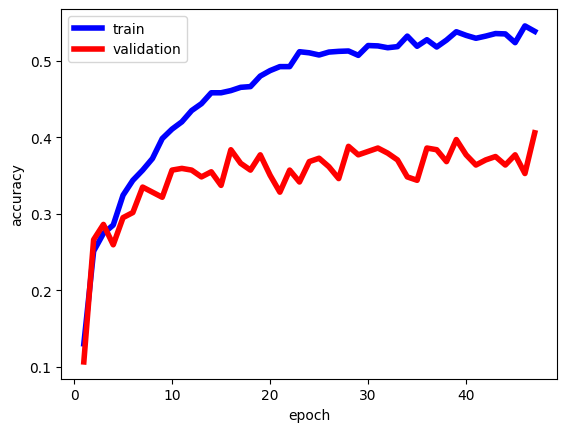

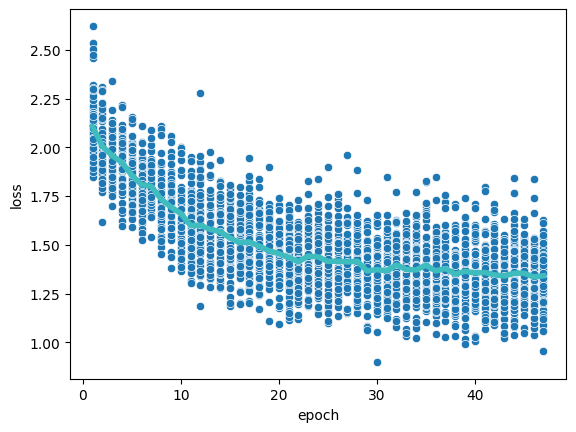

The Model Performance for ResNet:
Testing - Loss: 1.6609, Accuracy: 0.3496, Precision: 0.3271, Recall: 0.3496, F1 Score: 0.3255


In [10]:
# use ResNet for transfer learning
fix_random_seed()

# load the ResNet-50 model
resnet = models.resnet50(pretrained=True)

# modify the classifier to fit the guitar image data
resnet.fc = nn.Sequential(
    nn.Dropout(0.2),  # Apply dropout
    nn.Linear(2048, 1024),
    nn.ReLU(),
    nn.Linear(1024, 8)
)

# set up the hyperparameters
learning_rate = 1e-5
learning_rate_schedule = [10,20,30]
weight_decay = 1e-3
epochs = 47 # early stop to avoid overfitting

# use Kaiming initialization to initialize the weight
resnet.apply(lambda m: initialize_weight(m, init_type='kaiming'))
resnet.to(device)

# choose Adam as the optimizer
optimizer = optim.Adam(resnet.parameters(), 
                       lr = learning_rate, 
                       weight_decay = weight_decay
                      )


# train the model
train_acc,val_acc, result = train_model(model = resnet, 
                     optimizer = optimizer,
                     dataset = loader_train, 
                     epochs = epochs,
                     learning_rate_decay=0.4,
                     schedule = learning_rate_schedule,
                     validate = True)

# plot the accuracy and loss
plot_accuracy(train_acc,val_acc)
plot_loss(result)

# evaluate the performance using testing set
loss, accuracy, precision, recall, f1 = evaluate_model(resnet, loader_test, num_classes = 8)
print("The Model Performance for ResNet:")
print(f'Testing - Loss: {loss:.4f}, Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}')

In [11]:
# Save the ResNet model
with open('resnet_model.pkl', 'wb') as f:
    pickle.dump(resnet, f)

#### (2). Train Model with SqueezeNet Architecture

Epoch 0, Iteration 0, loss = 2.3066, val_loss = 2.0777, accuracy = 0.1310, val_accuracy = 0.1441
Epoch 1, Iteration 0, loss = 1.9936, val_loss = 2.0071, accuracy = 0.2354, val_accuracy = 0.1996
Epoch 2, Iteration 0, loss = 1.8417, val_loss = 1.9658, accuracy = 0.2454, val_accuracy = 0.2550
Epoch 3, Iteration 0, loss = 1.9207, val_loss = 1.9443, accuracy = 0.2525, val_accuracy = 0.2572
Epoch 4, Iteration 0, loss = 1.9855, val_loss = 1.9247, accuracy = 0.2824, val_accuracy = 0.2772
Epoch 5, Iteration 0, loss = 1.9737, val_loss = 1.9452, accuracy = 0.2871, val_accuracy = 0.2727
Epoch 6, Iteration 0, loss = 1.9517, val_loss = 1.8951, accuracy = 0.3170, val_accuracy = 0.2816
Epoch 7, Iteration 0, loss = 1.9610, val_loss = 1.9182, accuracy = 0.3227, val_accuracy = 0.2705
Epoch 8, Iteration 0, loss = 1.8360, val_loss = 1.8931, accuracy = 0.2947, val_accuracy = 0.2705
Epoch 9, Iteration 0, loss = 2.0921, val_loss = 1.9248, accuracy = 0.2881, val_accuracy = 0.2528
lr decay from 0.0001 to 4e-05


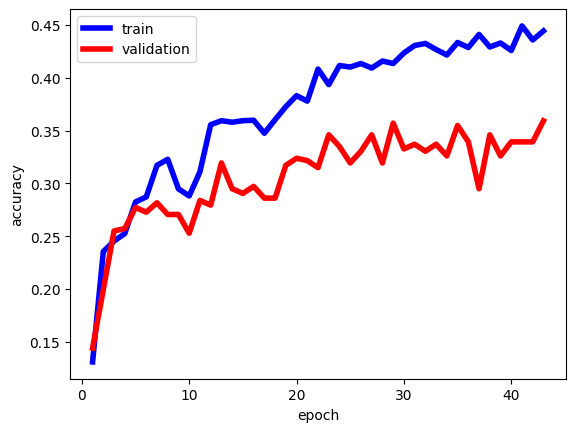

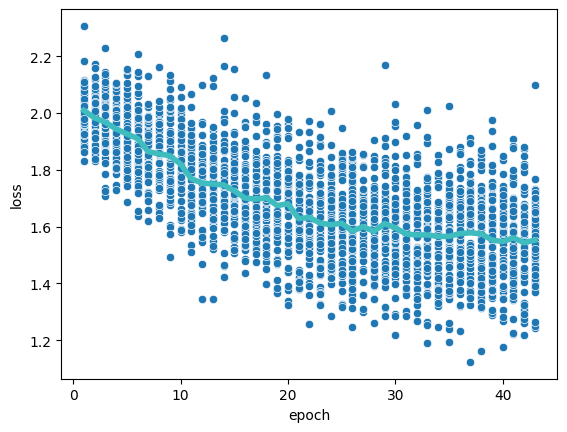

The Model Performance for SqueezeNet:
Testing - Loss: 1.7692, Accuracy: 0.3319, Precision: 0.3116, Recall: 0.3319, F1 Score: 0.3003


In [12]:
# use SqueezeNet for transfer learning
fix_random_seed()

# load the squeezenet model
squeezenet = models.squeezenet1_1(pretrained=True)

# modify the classifier to fit the guitar image data
squeezenet.classifier[1] = torch.nn.Conv2d(512, 8, kernel_size=1)
squeezenet.classifier[1].weight.data.normal_(0.0, 0.01)
squeezenet.classifier[1].bias.data.zero_()

# redefine the forward method directly
def custom_forward(x):
    x = squeezenet.features(x)
    x = squeezenet.classifier(x)
    return x.view(x.size(0), 8)

squeezenet.forward = custom_forward

# set up the hyperparameters
learning_rate = 1e-4
learning_rate_schedule = [10,20,30,40]
weight_decay = 1e-6
epochs = 43 # early stop to avoid overfitting

# use Kaiming initialization to initialize the weight
squeezenet.apply(lambda m: initialize_weight(m, init_type='kaiming'))
squeezenet.to(device)

# choose Adam as the optimizer
optimizer = optim.Adam(squeezenet.parameters(), 
                       lr = learning_rate, 
                       weight_decay = weight_decay
                      )

# train the model
train_acc, val_acc, result = train_model(model = squeezenet, 
                     optimizer = optimizer,
                     dataset = loader_train, 
                     epochs = epochs,
                     learning_rate_decay=0.4,
                     schedule = learning_rate_schedule,
                     validate = True)

# plot the accuracy and loss
plot_accuracy(train_acc,val_acc)
plot_loss(result)

# evaluate the performance using testing set
loss, accuracy, precision, recall, f1 = evaluate_model(squeezenet, loader_test, num_classes = 8)
print("The Model Performance for SqueezeNet:")
print(f'Testing - Loss: {loss:.4f}, Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}')

In [13]:
# Save the SqueezeNet model
with open('squeezenet_model.pkl', 'wb') as f:
    pickle.dump(squeezenet, f)

#### (3). Train Model with DenseNet Architecture

Epoch 0, Iteration 0, loss = 2.9343, val_loss = 2.6144, accuracy = 0.0930, val_accuracy = 0.1020
Epoch 1, Iteration 0, loss = 2.1306, val_loss = 1.9741, accuracy = 0.2810, val_accuracy = 0.2860
Epoch 2, Iteration 0, loss = 2.0204, val_loss = 1.8497, accuracy = 0.3446, val_accuracy = 0.2838
Epoch 3, Iteration 0, loss = 1.7663, val_loss = 1.7770, accuracy = 0.3882, val_accuracy = 0.3348
Epoch 4, Iteration 0, loss = 1.6241, val_loss = 1.7309, accuracy = 0.4352, val_accuracy = 0.3481
Epoch 5, Iteration 0, loss = 1.6985, val_loss = 1.7316, accuracy = 0.4457, val_accuracy = 0.3548
Epoch 6, Iteration 0, loss = 1.8796, val_loss = 1.7020, accuracy = 0.4832, val_accuracy = 0.3525
Epoch 7, Iteration 0, loss = 1.3242, val_loss = 1.7573, accuracy = 0.4888, val_accuracy = 0.3681
Epoch 8, Iteration 0, loss = 1.3905, val_loss = 1.8229, accuracy = 0.4466, val_accuracy = 0.3326
Epoch 9, Iteration 0, loss = 1.3574, val_loss = 1.5917, accuracy = 0.5795, val_accuracy = 0.4146
lr decay from 0.0001 to 1e-05


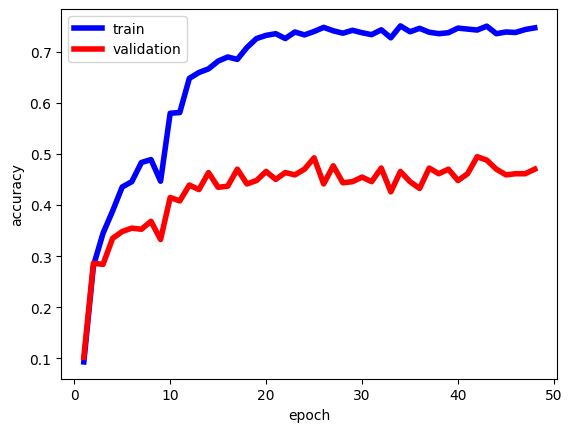

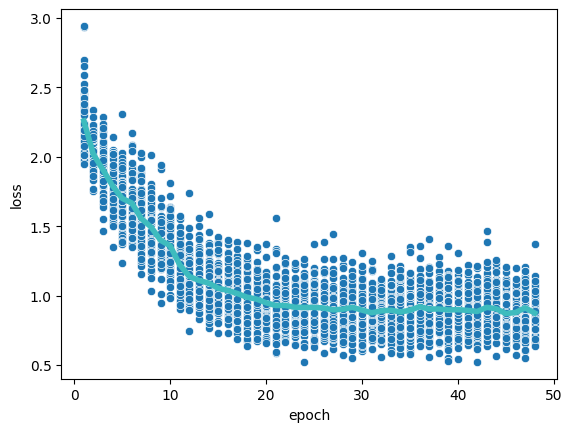

The Model Performance for DenseNet:
Testing - Loss: 1.5960, Accuracy: 0.4403, Precision: 0.4367, Recall: 0.4403, F1 Score: 0.4346


In [14]:
# use DenseNet for transfer learning
fix_random_seed()

# load the DenseNet model
densenet = models.densenet201(pretrained=True)

# modify the classifier to fit the guitar image data
densenet.classifier = nn.Sequential(
    nn.Dropout(0.5),  # Apply dropout
    nn.Linear(1920, 1024),
    nn.ReLU(),
    nn.Linear(1024, 8)
)

# set up the hyperparameters
learning_rate = 1e-4
learning_rate_schedule = [10,20,30,40]
weight_decay = 1e-5
epochs = 48

# use Kaiming initialization to initialize the weight
densenet.apply(lambda m: initialize_weight(m, init_type='kaiming'))
densenet.to(device)

# choose Adam as the optimizer
optimizer = optim.Adam(densenet.parameters(), 
                       lr=learning_rate, 
                       weight_decay = weight_decay
                      )

# train the model
train_acc,val_acc, result = train_model(model = densenet, 
                     optimizer = optimizer,
                     dataset = loader_train, 
                     learning_rate_decay = 0.1,
                     schedule = learning_rate_schedule,
                     epochs = epochs,
                     validate = True)

# plot the accuracy and loss
plot_accuracy(train_acc,val_acc)
plot_loss(result)

# evaluate the performance using testing set
loss, accuracy, precision, recall, f1 = evaluate_model(densenet, loader_test, num_classes = 8)
print("The Model Performance for DenseNet:")
print(f'Testing - Loss: {loss:.4f}, Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}')

In [15]:
# Save the DenseNet model
with open('densenet_model.pkl', 'wb') as f:
    pickle.dump(densenet, f)

#### (4). Train Model with VGG16 Architecture

Epoch 0, Iteration 0, loss = 2.7815, val_loss = 2.2397, accuracy = 0.1917, val_accuracy = 0.2151
Epoch 1, Iteration 0, loss = 1.8751, val_loss = 2.0001, accuracy = 0.2468, val_accuracy = 0.2550
Epoch 2, Iteration 0, loss = 2.0495, val_loss = 1.9828, accuracy = 0.2397, val_accuracy = 0.2572
Epoch 3, Iteration 0, loss = 1.8867, val_loss = 1.9837, accuracy = 0.2458, val_accuracy = 0.2639
Epoch 4, Iteration 0, loss = 2.2551, val_loss = 1.9694, accuracy = 0.2425, val_accuracy = 0.2594
Epoch 5, Iteration 0, loss = 1.8802, val_loss = 2.0429, accuracy = 0.1932, val_accuracy = 0.2062
Epoch 6, Iteration 0, loss = 2.0650, val_loss = 1.9772, accuracy = 0.2444, val_accuracy = 0.2550
Epoch 7, Iteration 0, loss = 1.6990, val_loss = 1.9597, accuracy = 0.2530, val_accuracy = 0.2550
Epoch 8, Iteration 0, loss = 1.9451, val_loss = 1.9747, accuracy = 0.2496, val_accuracy = 0.2550
Epoch 9, Iteration 0, loss = 2.0031, val_loss = 1.9937, accuracy = 0.2767, val_accuracy = 0.2483
lr decay from 0.0001 to 2e-05


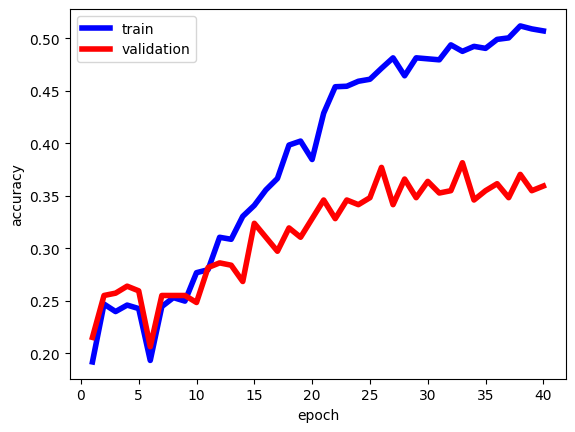

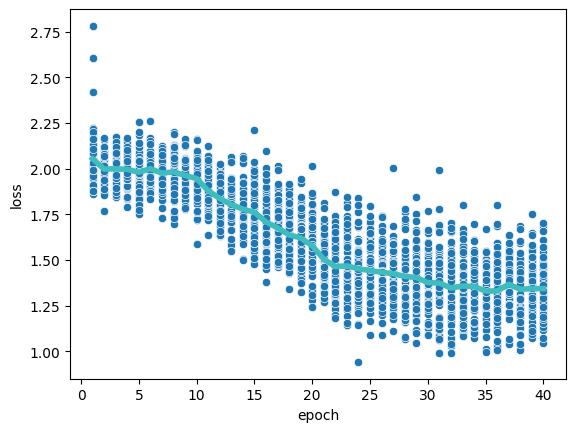

The Model Performance for VGG16:
Testing - Loss: 1.6790, Accuracy: 0.3805, Precision: 0.3676, Recall: 0.3805, F1 Score: 0.3556


In [16]:
# use VGG16 for transfer learning
fix_random_seed()

# load the VGG16 model
vgg16 = models.vgg16(pretrained=True)

# modify the classifier to fit the guitar image data
vgg16.classifier = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(25088, 1024),           
    nn.ReLU(),
    nn.Linear(1024, 8)  
)

# set up the hyperparameters
learning_rate = 1e-4
learning_rate_schedule = [10,20,30]
weight_decay = 1e-3
epochs = 40 # early stop to avoid overfitting

# use Kaiming initialization to initialize the weight
vgg16.apply(lambda m: initialize_weight(m, init_type='kaiming'))
vgg16.to(device)

optimizer = optim.Adam(vgg16.parameters(), 
                      lr = learning_rate, 
                      weight_decay = weight_decay
                      )

# train the model
train_acc,val_acc, result = train_model(model = vgg16, 
                     optimizer = optimizer,
                     dataset = loader_train, 
                     learning_rate_decay = 0.2,
                     schedule = learning_rate_schedule,
                     epochs = epochs,
                     validate = True)

# plot the accuracy and loss
plot_accuracy(train_acc,val_acc)
plot_loss(result)

# evaluate the performance using testing set
loss, accuracy, precision, recall, f1 = evaluate_model(vgg16, loader_test, num_classes = 8)
print("The Model Performance for VGG16:")
print(f'Testing - Loss: {loss:.4f}, Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}')

In [17]:
# Save the VGG16 model
with open('vgg16_model.pkl', 'wb') as f:
    pickle.dump(vgg16, f)